<a href="https://www.kaggle.com/code/arazan/nash-cs435?scriptVersionId=179329248" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Fashion Style Transfer**

**Research paper:** https://www.hindawi.com/journals/cin/2020/8894309/

**What is fashion style transfer?**<br>Fashion style transfer refers to the process of applying the pattern onto another garment. It involves using techniques from neural style transfer to transfer the visual style, textures, colors, and patterns of a style image onto content/base image while preserving the overall structure and content of the content image.

**Framework:**<br>
Process of image style transfer used in the research paper.<br>
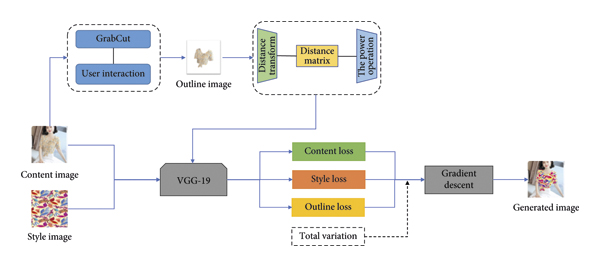

### **Step 0:** Importing all the required modules 

In [1]:
import cv2
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import os
from scipy.ndimage import distance_transform_edt
from scipy.ndimage.morphology import distance_transform_cdt
from scipy.ndimage import binary_dilation
from keras import backend as K
from keras.preprocessing.image import load_img, save_img, img_to_array, array_to_img
import matplotlib.pyplot as plt
from keras.applications.vgg19 import preprocess_input
from keras.applications import vgg19
from keras.models import Model
#from keras import optimizers
from scipy.optimize import fmin_l_bfgs_b
#from keras.applications.vgg19 import VGG19
#vgg19_weights = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
#vgg19 = VGG19(include_top = False, weights=vgg19_weights)
print(os.listdir("../input"))

Using TensorFlow backend.


['image-classification', 'random', 'best-artworks-of-all-time', 'vgg19']


### **Step 1:** Reading the inputs (Content image & Style image)

In [2]:
StylePath = '../input/random/'
ContentPath = '../input/random/'

base_image_path = ContentPath+'content_img2.jpg'
style_image_path = StylePath+'style_image.jpeg'

# Load content and style images
content_img = cv2.imread(base_image_path)
style_image = cv2.imread(style_image_path)

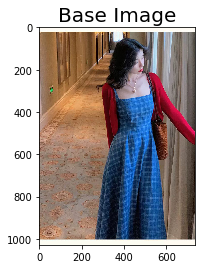

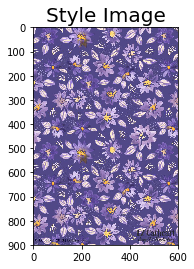

In [3]:
plt.figure()
plt.title("Base Image",fontsize=20)
img1 = load_img(base_image_path)
plt.imshow(img1)
plt.figure()
plt.title("Style Image",fontsize=20)
img1 = load_img(style_image_path)
plt.imshow(img1)

### **Step 2:** Creating outline image from content image<br>
This step uses GrabCut algorithm with modifiable rectangle for selecting cloth part from the content image

In [4]:
def apply_grabcut(content_img):
    # Create a mask to initialize GrabCut algorithm
    mask = np.zeros(content_img.shape[:2], np.uint8)
    # Adjust the rectangle to include only the desired region
    rect = (270, 270, 330, 730)  # Adjust as needed

    # Apply GrabCut algorithm
    cv2.grabCut(content_img, mask, rect,  None, None, 5, cv2.GC_INIT_WITH_RECT)

    # Create output mask
    output_mask = np.where((mask == 2) | (mask == 0), 0, 255).astype('uint8')

    # Apply bitwise operation to get the final outline image
    outline_image = content_img * output_mask[:, :, np.newaxis]
    
    return output_mask

outline_mask = apply_grabcut(content_img)

In [5]:
def invert_mask(outline_mask):
    # Invert the mask by subtracting from 255
    inverted_mask = 255 - outline_mask
    return inverted_mask

outline_mask = invert_mask(outline_mask)

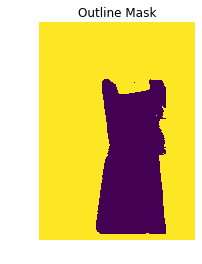

In [6]:
import matplotlib.pyplot as plt

cv2.imwrite('outline_mask.jpeg', outline_mask)
# Display the outline mask
plt.imshow(outline_mask)
plt.title('Outline Mask')
plt.axis('off')  # Hide axis ticks and labels
plt.show()

In [7]:
# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [8]:
import numpy as np
import keras.backend as K
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.applications.vgg19 import VGG19
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from skimage.transform import resize


def preprocess_image_instantiator(image_path, img_nrows, img_ncols):
    img = image.load_img(image_path, target_size=(img_nrows, img_ncols))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)


def get_content_loss(base, combination):
    return K.sum(K.square(combination - base))

def get_style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    return K.dot(features, K.transpose(features))

def preprocess_image(image_path):
    from keras.applications import vgg19
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def distance_transform_outline(outline_image_path):
    outline_img = image.load_img(outline_image_path, color_mode='grayscale')
    outline_array = image.img_to_array(outline_img)
    outline_array /= 255.0  # Normalize to range [0, 1]
    distance_transform = distance_transform_edt(outline_array)
    return distance_transform

def outline_loss(outline_image, combination_image):
    # Calculate distance transform of the outline image
    distance_transform = distance_transform_outline(outline_image)
    
    # Resize the distance transform to match the shape of the combination image
    resized_distance_transform = resize(distance_transform, (int(combination_image.shape[1]), int(combination_image.shape[2])))
    
    # Perform element-wise multiplication between the combination image and the resized distance transform
    combination_feature = combination_image * resized_distance_transform
    
    # Calculate the loss
    return K.sum(K.square(combination_feature))

def total_variation_loss(combination_image):
    a = K.square(combination_image[:, :img_nrows-1, :img_ncols-1, :] - combination_image[:, 1:, :img_ncols-1, :])
    b = K.square(combination_image[:, :img_nrows-1, :img_ncols-1, :] - combination_image[:, :img_nrows-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

### **Step 3:** Calculating loss based on their features
Gram matrix is used in calculating loss

In [9]:
outline_image_path = 'outline_mask.jpeg'
width, height = image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

base_image = K.variable(preprocess_image_instantiator(base_image_path, img_nrows, img_ncols))
style_reference_image = K.variable(preprocess_image_instantiator(style_image_path, img_nrows, img_ncols))
outline_image = K.variable(preprocess_image_instantiator(outline_image_path, img_nrows, img_ncols))

if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              outline_image,
                              combination_image], axis=0)

vgg19_weights = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
model = VGG19(input_tensor=input_tensor,
          include_top = False,
          weights=vgg19_weights)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

content_weight = 0.025
style_weight = 1.0
outline_weight = 1.0
total_variation_weight = 1.0

loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[3, :, :, :]
loss += content_weight * get_content_loss(base_image_features, combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[3, :, :, :]
    sl = get_style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

loss += outline_weight * outline_loss(outline_image_path, combination_image)
loss += total_variation_weight * total_variation_loss(combination_image)


Instructions for updating:
Colocations handled automatically by placer.


### **Step 4:**  Calculation of gradient with respect to loss


In [10]:
grads = K.gradients(loss, combination_image)
outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = K.function([combination_image], outputs)

In [11]:
x_opt = preprocess_image(base_image_path)

The purpose of this **Evaluator** class is to avoid the error **'numpy.ndarray' object is not callable error with optimize.minimize** while running the L-BFGS optimizer for loss minimization.<br>
You should pass the function itself to minimize, instead of a evaluated value. <br>

In [12]:
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_nrows, img_ncols, 3))
        outs = f_outputs([x])
        loss_value = outs[0]
        grad_values = np.array(outs[1:]).flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [13]:
evaluator = Evaluator()
iterations = 500
best_loss, best_img = float('inf'), None

for i in range(iterations):
    print('Start of iteration', i)
    x_opt, min_val, info= fmin_l_bfgs_b(evaluator.loss, 
                                        x_opt.flatten(), 
                                        fprime=evaluator.grads,
                                        maxfun=20,
                                        disp=True,
                                       )
    print('Current loss value:', min_val)
    if min_val < best_loss:
        # Update best loss and best image from total loss. 
        best_loss = min_val
        best_img = x_opt.copy()

Start of iteration 0
Current loss value: 107618580000.0
Start of iteration 1
Current loss value: 32615064000.0
Start of iteration 2
Current loss value: 19985994000.0
Start of iteration 3
Current loss value: 15832374000.0
Start of iteration 4
Current loss value: 12711097000.0
Start of iteration 5
Current loss value: 11264211000.0
Start of iteration 6
Current loss value: 10047099000.0
Start of iteration 7
Current loss value: 9177412000.0
Start of iteration 8
Current loss value: 8620438000.0
Start of iteration 9
Current loss value: 8177887000.0
Start of iteration 10
Current loss value: 7707164000.0
Start of iteration 11
Current loss value: 7287469000.0
Start of iteration 12
Current loss value: 7000950000.0
Start of iteration 13
Current loss value: 6764074500.0
Start of iteration 14
Current loss value: 6528561000.0
Start of iteration 15
Current loss value: 6334638600.0
Start of iteration 16
Current loss value: 6174486500.0
Start of iteration 17
Current loss value: 6044613600.0
Start of ite

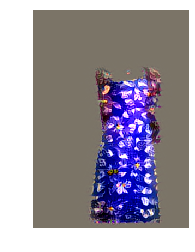

In [14]:
# Example usage:
imgx = deprocess_image(best_img.copy())
plt.imshow(imgx)
plt.axis('off')
plt.show()

### **Step 5:** Creating final image
Final image is created using cv operations on base image, stylized image from the previous step and our outline image

In [15]:
print(imgx.shape)
content_img = cv2.imread(base_image_path)
content_img_resized = cv2.resize(content_img, (imgx.shape[1], imgx.shape[0]))
print(content_img_resized.shape)
# Resize the outline mask to match the dimensions of the image array
outline_mask_resized = cv2.resize(outline_mask, (content_img_resized.shape[1], content_img_resized.shape[0]))
print(outline_mask_resized.shape)

(400, 286, 3)
(400, 286, 3)
(400, 286)


(400, 286)


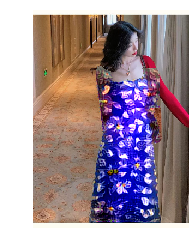

In [16]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


# Load the outline mask
outline_mask = cv2.imread('outline_mask.jpeg', cv2.IMREAD_GRAYSCALE)
outline_mask = 255 - outline_mask  # Invert the outline mask
outline_mask = cv2.resize(outline_mask, (content_img_resized.shape[1], content_img_resized.shape[0]))
print(outline_mask.shape)

# Create a mask for the cloth region in imgx
cloth_mask_imgx = outline_mask.astype(np.uint8)

# Combine the cloth mask from imgx with the inverse of the outline mask
cloth_mask_combined = cv2.bitwise_and(outline_mask, cloth_mask_imgx)

# Blend the cloth region from imgx with the corresponding region in the base image
result_image = content_img_resized.copy()
result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
result_image[cloth_mask_combined > 0] = imgx[cloth_mask_combined > 0]

plt.imshow(result_image)
plt.axis('off')
plt.show()


## **References:** 
Code Reference: https://www.kaggle.com/code/basu369victor/style-transfer-deep-learning-algorithm/ <br>
This code uses art style transfer on the whole image.